# Analyze`TedSim` grid-search results w/ subsampling 

Application of `moslin` on `TedSim` simulations [[PHX-22]](https://doi.org/10.1093/nar/gkac235).


# Preliminaries

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import utils_run
from utils_analysis import state_tree_draw, tree_draw, plot_cost, node_colors

import glob

import moscot as mc

In [3]:
mc.__version__

'0.3.4.dev158+gee31deb'

In [4]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

## Dependencies

Run `data_generation` and `experiments` according to the instructions in the README

## Set up paths

Define the paths for data and figures

In [5]:
sys.path.insert(
    0, "../../../"
)  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

FIG_DIR = FIG_DIR / "simulations/pan_tedsim"
DATA_DIR = DATA_DIR / "simulations/pan_tedsim"
LOG_DIR = DATA_DIR / "simulations/pan_tedsim"

### Create data grid

In [6]:
seeds = [36489, 59707, 38128, 25295, 49142, 12102, 30139, 4698, 50349, 23860]
ssrs = [0.2]
depth = 8
subsamples = [0.4, 0.6, 0.8, 0.9]

config = []
for seed in seeds:
    for ssr in ssrs:
        for subsample in subsamples:
            config.append([seed, ssr, depth, subsample])

df = pd.DataFrame(config, columns=["seed", "ssr", "depth", "subsample"])
df.index.name='ArrayTaskID'
df.to_csv(LOG_DIR / "grid_config_subsample.txt", sep="\t")

## Set global parameters

In [7]:
import mplscience

mplscience.set_style()
plt.rcParams["legend.scatterpoints"] = 1
plt.rcParams["figure.dpi"] = 300

# Import grid results

In [8]:
filenames = glob.glob("/cs/labs/mornitzan/zoe.piran/research/projects/moslin_analysis_2/data/simulations/pan_tedsim_rev/output_subsample/*.csv")
filenames_res = [file for file in filenames if "cluster" not in file]
filenames_clust = [file for file in filenames if "cluster" in file]
filenames_clust = [file for file in filenames_clust if "gt" not in file]
filenames_clust_gt = [file for file in filenames_clust if "gt" in file]

In [9]:
res = None
for file in filenames_res:
    dfc = pd.read_csv(file)
    dfc["subsample"] = float(file.split("_")[-1].strip(".csv"))
    dfc["pct_removed"] = 1-dfc["subsample"]
    if "gt" in file:
        continue
    if res is None:
        res = dfc
    else:
        res = pd.concat([res, dfc], ignore_index=True)

In [10]:
res["mean_cost"] = (res["early_cost"] + res["late_cost"]) / 2
res = res.drop(columns="Unnamed: 0")

In [11]:
res["kind"].unique()

array(['moslin', 'CoSpar', 'LineageOT'], dtype=object)

In [12]:
for df in [res]:
    df.loc[df["alpha"] == 0.0, "kind"] = "OT"
    df.loc[df["alpha"] == 1.0, "kind"] = "GW"

In [13]:
res.loc[res["tree_type"] == "fitted-tree","kind"] = res["kind"] + " (fitted-tree)"
res.loc[res["tree_type"] == "ground-truth","kind"] =  res["kind"] + " (ground-truth)"
res.loc[res["tree_type"] == "state-only","kind"] = res["kind"] + " (state-only)"

In [14]:
idx = (
    res.groupby(
        ["p_a", "ssr", "ss", "kind", "data_seed", "subsample"]
    )["mean_cost"].transform(min)
    == res["mean_cost"]
)
df_min = res[idx]

In [15]:
df_min[(df_min["kind"] == "moslin") & (df_min["data_seed"] == 38128)]

,p_a,ss,ssr,data_seed,alpha,epsilon,scale_cost,depth,seed,kind,converged,early_cost,late_cost,tree_type,subsample,pct_removed,mean_cost
24,0.4,0.4,0.3,38128,0.990,0.0001,mean,8,1427845748,moslin,False,0.487528,0.472320,bc,0.6,0.4,0.479924
717,0.4,0.4,0.3,38128,0.990,0.0001,mean,8,2647875444,moslin,False,0.495400,0.487120,bc,0.4,0.6,0.491260
1022,0.4,0.4,0.2,38128,0.990,0.0001,mean,8,381580472,moslin,False,0.442806,0.448618,bc,0.4,0.6,0.445712
1407,0.4,0.4,0.2,38128,0.990,0.0001,mean,8,300092412,moslin,False,0.427702,0.427679,bc,0.6,0.4,0.427690
1447,0.4,0.4,0.3,38128,0.990,0.0001,mean,8,3195379924,moslin,False,0.480239,0.452658,bc,0.9,0.1,0.466448
2021,0.4,0.4,0.2,38128,0.999,0.0001,mean,8,3933538348,moslin,False,0.425930,0.413102,bc,0.9,0.1,0.419516
2322,0.4,0.4,0.3,38128,0.990,0.0001,mean,8,1378075952,moslin,False,0.499580,0.475439,bc,0.8,0.2,0.487509


In [16]:
df_min["pct_removed"].unique()

array([0.4, 0.1, 0.2, 0.6])

# Plot Res

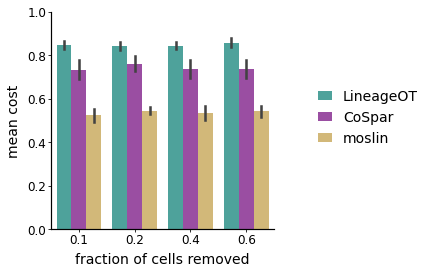

In [17]:
p_a = 0.4
step_size = 0.4
ssr = 0.2
df_min_ss = df_min[(df_min["ss"] == step_size) & (df_min["ssr"] == ssr)]
subsamples = np.sort(df_min_ss["pct_removed"].unique())
hue_order = ["LineageOT", "CoSpar", "moslin"]
method_colors = {
    "moslin": "#E1BE6A",
    "CoSpar": "#A640B0",
    "LineageOT": "#40B0A6",
}

fontsize = 14

rows = 1
cols = len(subsamples)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

colors = {method: method_colors[method] for method in hue_order}
ax = sns.barplot(
    x="pct_removed",
    y="mean_cost",
    hue="kind",
    hue_order=hue_order,
    data=df_min_ss,
    ax=axs,
    palette=colors,
)


ax.set_xticklabels([0.1, 0.2, 0.4, 0.6])
ax.set_xlabel("fraction of cells removed")
ax.set_ylabel("mean cost", fontsize=fontsize)
ax.set_ylim(0, 1)
ax.legend(
    ncol=1,
    handlelength=1,
    fontsize=fontsize,
    # labelspacing=0.1,
    columnspacing=1,
    loc="upper right",
    bbox_to_anchor=(1.2, 0.2, 0.5, 0.5),
)

# plt.savefig(
#     FIG_DIR / 
#     "ssr_ss0.4_pa0.4_ssr0.2_depth_8_subsample.pdf", bbox_inches="tight", dpi=300, format="pdf"
# )

plt.show()

In [18]:
p_a = 0.4
ss = 0.4
ssr = ssr
sample_times = {"early": depth * TTP, "late": MAX_DEPTH * TTP}


NameError: name 'TTP' is not defined

# References


[[PHX-22] Pan, X., Li, H., & Zhang, X. (2022). TedSim: temporal dynamics simulation of single-cell RNA sequencing data and cell division history. Nucleic Acids Research, 50(8), 4272-4288.](https://doi.org/10.1093/nar/gkac235)